# Example: Prototypes with Embeddings 

This notebook is an example of how to use the PrototypeFullModel class
to simultaneously learn prototypes *and* an input embedding. 

## Prepare environment

In [1]:
import sys
sys.path.append("..")
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv2D, MaxPooling2D

from protolearn.model_wrapper import PrototypeFullModel

2024-01-09 11:42:56.025025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare data
We'll use some digits of the MNIST dataset and simulate a regression task (the goal is that regression should output a 1.0 for digits of type 1, etc). 

In [2]:
# Load MNIST data

N_GROUPS = 3

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Keep only 0s and 1s
x_train = x_train[y_train < N_GROUPS]
y_train = y_train[y_train < N_GROUPS]
x_test = x_test[y_test < N_GROUPS]
y_test = y_test[y_test < N_GROUPS]

# Normalize data
x_train = x_train / 255.
x_test = x_test / 255.

## Model

First, we need to define the architecture of the embedding network. 

In [3]:
# Define an embedding network
embedding_network = Sequential()
embedding_network.add(Input(shape=(28, 28)))
embedding_network.add(Flatten())
embedding_network.add(Dense(32, activation='relu'))
embedding_network.add(Dense(2, activation='linear'))

In [4]:
embedding_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 25186 (98.38 KB)
Trainable params: 25186 (98.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we can create a `PrototypeFullModel` instance, as in the previous notebooks, but passing the extra argument `network`. 

You might also want to use the optional sample regularization term, by setting the argument `regularize_samples=True`.

In [5]:
ETA = 0.01
model = PrototypeFullModel(
    n_prototypes=15,
    scale=1.0,
    reg_constant=ETA,
    learning_rate=1e-3,
    epochs=50,
    batch_size=256,
    verbose=True,
    restart=False,
    trainable_scales=True,
    network=embedding_network,
    regularize_samples=True,
)

### Model training

In [6]:
model.fit(x_train, y_train)

582/582 [==============================] - 0s 609us/step


/Users/jose_esade/Documents/code/prototype_based_learning/.env_proto/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


[[ 0.42049092  0.6642982 ]
 [ 1.2468214  -0.44972175]
 [ 2.4282904  -1.0678188 ]
 [ 0.8490207  -0.77572656]
 [ 3.1553214  -0.23225151]
 [ 1.8180974  -1.6773549 ]
 [ 2.297157   -0.5670104 ]
 [ 0.797037    1.0589415 ]
 [ 0.36116534  0.36326668]
 [ 1.8690201  -1.0298032 ]
 [ 1.003881   -0.5977107 ]
 [ 2.1594424  -1.376     ]
 [ 0.74124104  0.45136717]
 [ 0.5958614   0.8422854 ]
 [ 2.7958345  -0.6857458 ]]
Epoch 1/50
73/73 [==============================] - 1s 2ms/step - loss: 0.0248 - mean_of_radii: 0.1802 - mean_sample_dist: 0.5851
Epoch 2/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0159 - mean_of_radii: 0.1501 - mean_sample_dist: 0.3908
Epoch 3/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0126 - mean_of_radii: 0.1195 - mean_sample_dist: 0.3005
Epoch 4/50
73/73 [==============================] - 0s 2ms/step - loss: 0.0099 - mean_of_radii: 0.1000 - mean_sample_dist: 0.2504
Epoch 5/50
73/73 [==============================] - 0s 2ms/step - loss: 0.

PrototypeFullModel(epochs=50, n_prototypes=15,
                   network=<keras.src.engine.sequential.Sequential object at 0x7fe4cc7e10d0>,
                   reg_constant=0.01, regularize_samples=True, scale=1.0,
                   trainable_scales=True, verbose=True)

## Model interpretation

First, let's display a few digits and verify that the result of the regression approaches the digit. 

1/1 [==============================] - 0s 17ms/step


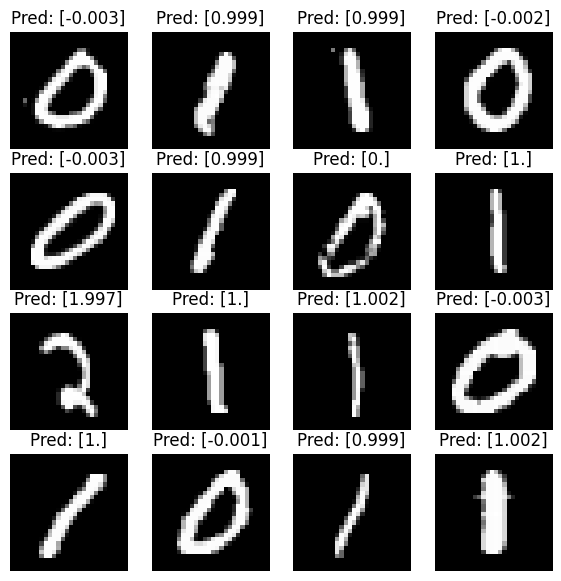

In [7]:
# Display 4x4 test images

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(4, 4, figsize=(7, 7))

for i in range(4):
    for j in range(4):
        idx = np.random.randint(len(x_test))
        axs[i, j].imshow(x_test[idx], cmap='gray')
        axs[i, j].set_title(f"Pred: {np.round(model.predict(x_test[idx:idx+1])[0], 3)}")
        axs[i, j].axis('off')

Next, let's plot the digits and prototypes in the embedding space. 

99/99 [==============================] - 0s 683us/step


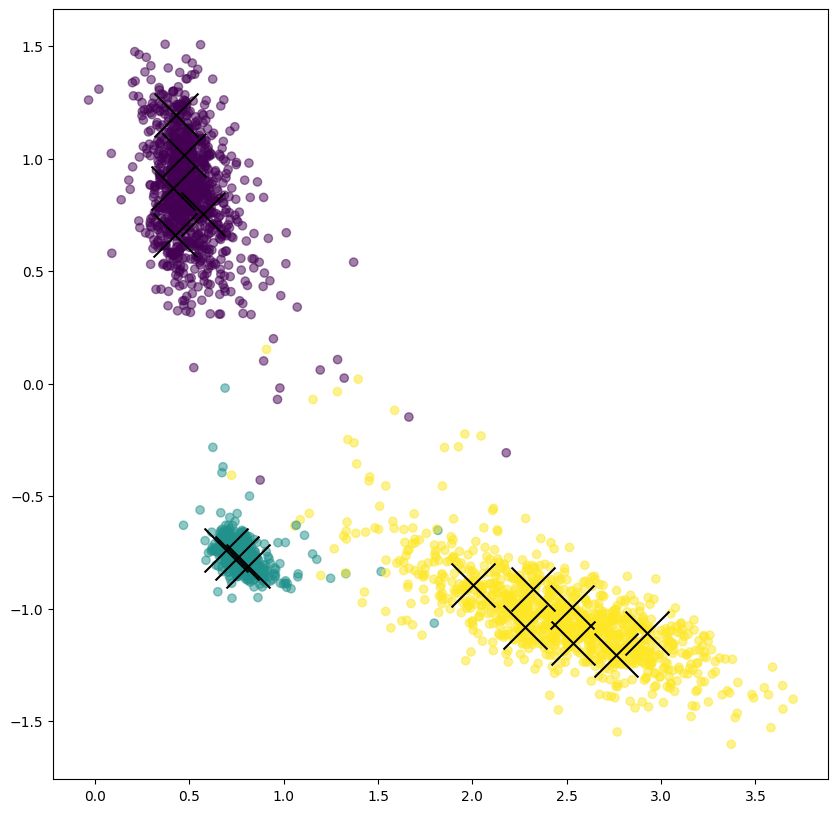

In [8]:
prototypes = model.get_prototypes()

# Display projections of test set
model.epochs = 1
model.fit(x_train, y_train)
fig, ax = plt.subplots(figsize=(10, 10))
xproj = model._embedding_model.predict(x_test)
ax.scatter(xproj[:, 0], xproj[:, 1], c=y_test, alpha=0.5)

# Display prototypes
ax.scatter(prototypes[:,0], prototypes[:, 1], c='black', s=1000, marker='x')

Finally, let's display the images of digits closest to each prototype. 

582/582 [==============================] - 0s 575us/step


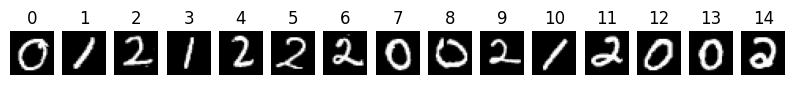

In [9]:
# Display image closest to each prototype

fig, axs = plt.subplots(1, prototypes.shape[0], figsize=(10, 10))

embeddings = model._embedding_model.predict(x_train)
for i in range(prototypes.shape[0]):
    idx = np.argmin(np.linalg.norm(embeddings - model.get_prototypes()[i], axis=1))
    axs[i].imshow(x_train[idx], cmap='gray')
    axs[i].set_title(f"{i}")
    axs[i].axis('off')

(And inspect the prototype values to make sure they fall within the expected ranges)

In [10]:
model.get_prototype_values()

array([ 0.00614688,  1.0412031 ,  1.8643408 ,  1.0693272 ,  2.0688295 ,
        2.086323  ,  2.0706732 ,  0.02284535, -0.04282672,  2.1539972 ,
        0.84807396,  1.9675056 , -0.10294557,  0.04980255,  2.0022264 ],
      dtype=float32)